In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.homography import get_homography, apply_homography
from utils.calibration import reconstruct_k

In [13]:
sift = cv2.SIFT_create()
matcher = cv2.FlannBasedMatcher()

(np.float64(-0.5), np.float64(4079.5), np.float64(3071.5), np.float64(-0.5))

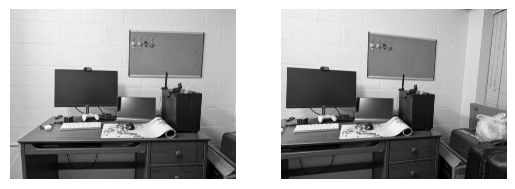

In [14]:
img1 = cv2.cvtColor(cv2.imread('./data/real/scene/desk0.jpg'), cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(cv2.imread('./data/real/scene/desk1.jpg'), cv2.COLOR_BGR2GRAY)
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.axis('off')

In [15]:
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [16]:
matches = matcher.knnMatch(des1, des2, k=2)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

In [17]:
final_matches = sorted(good_matches, key=lambda x: x.distance)[:400]

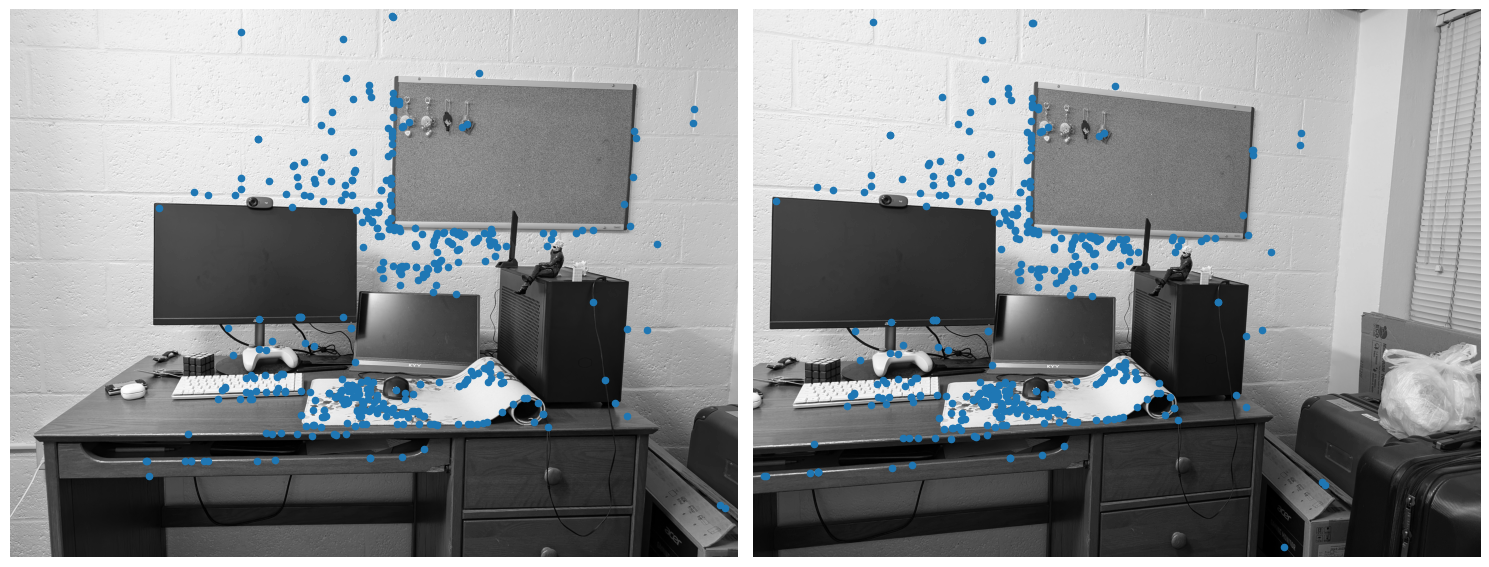

In [18]:
# queryIdx is the index of the feature in kp1 of the first image
# trainIdx is the index of the feature in kp2 of the second image
X1 = np.array([kp1[match.queryIdx].pt for match in final_matches])
X2 = np.array([kp2[match.trainIdx].pt for match in final_matches])

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.scatter(X1[:, 0], X1[:, 1], s=20)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.scatter(X2[:, 0], X2[:, 1], s=20)
plt.axis('off')
plt.tight_layout()

In [19]:
def ransacH(X1, X2):
    # set up ransac
    rng = np.random.default_rng()
    n = X1.shape[0]

    num_iters = 100
    distance_threshold = 2

    best_idxs = None
    best_count = 0
    for _ in range(num_iters):
        # pick 4 random points and find the homography matrix H
        idxs = rng.choice(n, size=4, replace=False)
        X = X1[idxs]
        Xp = X2[idxs]
        H = get_homography(X, Xp)

        # calculate expected X2 values based on H
        theoretical_X2h = np.hstack([X1, np.ones((n, 1))]) @ H.T
        theoretical_X2 = theoretical_X2h[:, :2] / theoretical_X2h[:, 2:]

        # find consensus set based on L2 distance between X2 and expected
        distances = np.sqrt(((X2 - theoretical_X2) ** 2).sum(axis=1))
        inlier_mask = distances <= distance_threshold ** 2
        inlier_count = inlier_mask.sum()
        inlier_idxs = inlier_mask.nonzero()
        if inlier_count > best_count:
            best_count = inlier_count
            best_idxs = inlier_idxs

    # with the best consensus set, re-fit H and return
    X, Xp = X1[best_idxs], X2[best_idxs]
    H = get_homography(X, Xp, normalize=True)
    return H

In [20]:
def run_calibrate(imgs):
    n = len(imgs)
    sift = cv2.SIFT_create()
    matcher = cv2.FlannBasedMatcher()

    sifts = [sift.detectAndCompute(img, None) for img in imgs]
    kps, dess = zip(*sifts)

    Hs = []

    for i in range(1, n):
        matches = matcher.knnMatch(dess[0], dess[i], k=2)
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        
        final_matches = sorted(good_matches, key=lambda x: x.distance)[:100]
        X1 = np.array([kps[0][match.queryIdx].pt for match in final_matches])
        X2 = np.array([kps[i][match.trainIdx].pt for match in final_matches])
        H = ransacH(X1, X2)
        Hs.append(H)

    A = np.zeros((0, 6))
    for H in Hs:
        H_inv = np.linalg.inv(H)

        h1, h2, h3, h4, h5, h6, h7, h8, h9 = H_inv.ravel()

        row1 = np.array([h1**2 - 1, 2*h1*h4, 2*h1*h7, h4**2, 2*h4*h7, h7**2])
        row2 = np.array([h1*h2, h1*h5+h2*h4 - 1, h1*h8+h2*h7, h4*h5, h4*h8+h5*h7, h7*h8])
        row3 = np.array([h1*h3, h1*h6+h3*h4, h1*h9+h3*h7 - 1, h4*h6, h4*h9+h6*h7, h7*h9])
        row4 = np.array([h2**2, 2*h2*h5, 2*h2*h8, h5**2 - 1, 2*h5*h8, h8**2])
        row5 = np.array([h2*h3, h2*h6+h3*h5, h2*h9+h3*h8, h5*h6, h5*h9+h6*h8 - 1, h8*h9])
        row6 = np.array([h3**2, 2*h3*h6, 2*h3*h9, h6**2, 2*h6*h9, h9**2 - 1])

        A = np.vstack([A, row1, row2, row3, row4, row5, row6])

    _, _, Vt = np.linalg.svd(A)
    w_coeffs = Vt[5, :]
    K = reconstruct_k(w_coeffs)
    return K

In [21]:
image_fnames = [f'./data/real/scene/desk{i}.jpg' for i in range(7)]
images = [cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2GRAY) for fname in image_fnames]

K = run_calibrate(images)
K

array([[ 2.25517698e+03,  6.54079753e+02,  2.06211567e+03],
       [-0.00000000e+00,  2.37827638e+03,  2.10373969e+03],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00]])

In [11]:
temp = np.hstack([X1, np.ones((X1.shape[0], 1))])
temp = temp @ H.T
temp = temp[:, :2] / temp[:, 2:]

NameError: name 'H' is not defined

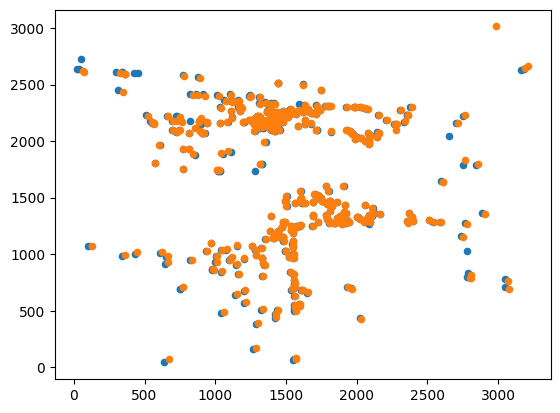

In [ ]:
plt.scatter(temp[:, 0], temp[:, 1], s=20)
plt.scatter(X2[:, 0], X2[:, 1], s=20)